# Predict KBO

## KBO 정규 리그 우승팀 및 포스트 시즌 진출 팀 예측

최근 10년간의 정규리그 성적을 바탕으로 2019 시즌 우승팀과 플레이오프 진출팀을 예측하는

머신러닝 모델을 만들어 보자.


### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-colorblind')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Data Set

분석 자료는 한국야구위원회 공식 홈페이지 기록실에서 추출한 팀기록을 사용하였다.  

링크 (https://www.koreabaseball.com/Record/Player/HitterBasic/Basic1.aspx)


In [3]:
# Read Data 
df = pd.read_csv('./data/kbo_data.csv')

In [4]:
df.head(5)

,WIN,POST,YEAR,TEAM,AVG,G,PA,AB,R,H,...,PB,SB_A,CS_A,CS%,SBA,SB,CS,SB%,OOB,PKO.1
0,N,N,2010,넥센,0.262,133,5139,4452,570,1165,...,9,160,68,29.8,191,135,56,70.7,56,5
1,N,Y,2010,두산,0.281,133,5252,4538,731,1276,...,8,119,44,27.0,189,128,61,67.7,56,12
2,N,Y,2010,롯데,0.288,133,5261,4673,773,1345,...,6,131,62,32.1,175,124,51,70.9,62,7
3,N,Y,2010,삼성,0.272,133,5287,4436,681,1207,...,6,134,65,32.7,213,158,55,74.2,54,8
4,N,N,2010,한화,0.244,133,5009,4321,543,1053,...,7,151,58,27.8,191,121,70,63.4,56,11


### Features (예측 변수)

우선, 2019년 시즌은 현재 진행 중이므로, 안타수, 홈런수 등의 총 합 데이터는 지양하고,  
비율로 구성된 값들만을 예측 변수로 사용해 초기 모델을 만들어 보자.

- AVG : batting AVeraGe (타율)
- OPS : On base Plus Slugging (출루율 + 장타율)
- RISP : batting AVG at Runner In Scoring Position (득점권타율)
- PH-BA : Pinch Hitter - Batting Average (대타 타율)
- ERA : Earned Runs Average (평균자책점)
- WHIP : Walks Plus Hits Divided by Innings Pitched (이닝당출루허용)
- FPCT : Fielding PerCenTage (수비율)

In [5]:
# features : AVG, OPS, RISP(Runner In Scoring Position) AVG, 
# PH-BA(Pinch Hitter - Batting Average), ERA, WHIP, FPCT(Fielding PerCenTage)
features = ['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT']

In [6]:
list(df.loc[df['WIN'] == 1, features])

['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT']

In [7]:
# Check the stats of Winners
win = df.loc[df['WIN'] == 'Y', features].mean()

In [8]:
post = df.loc[df['POST'] == 'Y', features].mean()

In [9]:
all = df.loc[:, features].mean()

In [10]:
feature_df = pd.DataFrame(zip(features,win,post,all), columns=['CATE','WIN', 'POST', 'ALL'])

In [11]:
feature_df

,CATE,WIN,POST,ALL
0,AVG,0.288889,0.283375,0.277488
1,OPS,0.805778,0.791275,0.770037
2,RISP,0.300111,0.289775,0.281634
3,PH-BA,0.225222,0.232250,0.228427
4,ERA,4.206667,4.441000,4.732683
5,WHIP,1.384444,1.423000,1.472683
6,FPCT,0.984444,0.982925,0.982195


In [12]:
# Korean Font for Chart Title
title_font = fm.FontProperties(fname='/Library/Fonts/NanumGothicBold.ttf', size=20)

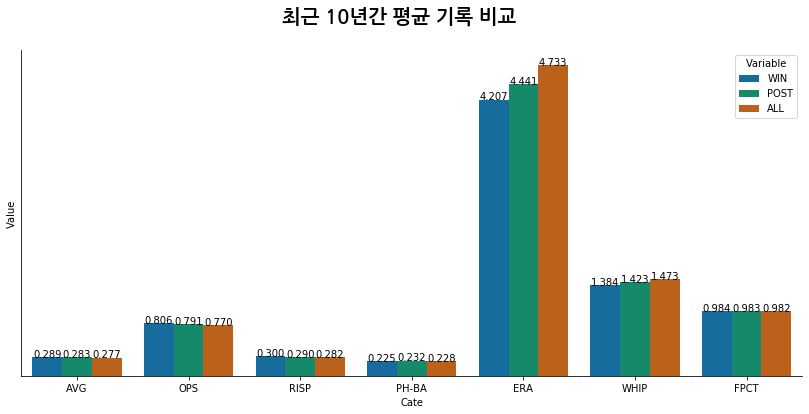

In [13]:
fig, ax = plt.subplots(figsize=(14, 6))
graph_df = feature_df.melt(id_vars='CATE').rename(columns=str.title)
sns.barplot(x='Cate', y='Value', hue='Variable', data=graph_df, ax=ax)
sns.despine(fig)

ax.grid(False)
ax.set_yticks([])

fig.suptitle('최근 10년간 평균 기록 비교', fontproperties=title_font)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    label = '{:.3f}'.format(y_value)
    plt.annotate(label, (x_value, y_value), ha='center', fontsize=10)
    
plt.show()

우승, 포스트시즌 진출 팀의 각 기록이 전체팀과 비교해서 약간의 차이를 보이므로,   
이 변수들을 활용해서 우승 확률과 포스트 시즌 진출 확률을 예측 가능할 것으로 판단됨

#### 데이터 정리와 타겟 변수 설정

In [14]:
# Cleaning Data for Classifier
df['WIN'] = df['WIN'].map(lambda x: 0 if x == 'N' else 1)
df['POST'] = df['POST'].map(lambda x: 0 if x == 'N' else 1)

In [15]:
# Set target data frames
win_y = df['WIN']
post_y = df['POST']

In [16]:
# Only pick the features with Ratio because it is middle of season
ratio_X = df[features]

In [17]:
# Split data set for train & test model
X_train, X_test, y_train, y_test = train_test_split(ratio_X, win_y, test_size=.2)

#### 로지스틱 회귀분석 모형을 사용해 초기 예측 모델 생성

In [18]:
# Set pipeline with SS & Log_Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs',
                                      random_state=27))
])

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=27, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

#### Check Performance of Model

In [20]:
test_preds = pipeline.predict(X_test)

In [21]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17

   micro avg       1.00      1.00      1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [22]:
# current(1st of June) stat of KBO leagues 
stat_0601 = {
    'SK': [.251, .702, .282, .289, 3.64, 1.34, .982],
    'DOOSAN': [.273, .760, .271, .094, 3.13, 1.28, .985],
    ' LG': [.259, .686, .247, .209, 3.25, 1.26, .984],
    'NC': [.291, .796, .288, .129, 4.16, 1.38, .980],
    'KIWOOM': [.285, .776, .308, .237, 4.25, 1.37, .983],
    'HANWHA':[.253, .701, .259, .119, 4.67, 1.52, .982],
    'KT': [.270, .715, .267, .200, 4.86, 1.50, .977],
    'KIA': [.262, .713, .252, .154, 5.06, 1.56, .985],
    'SAMSUNG': [.266, .739, .256, .292, 4.39, 1.39, .978],
    'LOTTE': [.269, .718, .271, .224, 5.87, 1.70, .978],
}

In [23]:
# Odds for Winning the 2019
for team, value in stat_0601.items():
    print(f'{team} :  {pipeline.predict_proba([value])[0][1]*100:.4}%')

SK :  2.606%
DOOSAN :  87.64%
 LG :  5.798%
NC :  34.02%
KIWOOM :  45.94%
HANWHA :  0.3245%
KT :  0.04998%
KIA :  0.2614%
SAMSUNG :  0.05701%
LOTTE :  0.003557%


#### 1차 결론

우승 확률이 계산되긴 하나, 10년 동안의 데이터가 고작 100건 밖에 안되고,   
우승팀이 10건 밖에 되지 않기 때문에 신뢰도는 그다지 높지 못하다고 할 수 있다.

#### 전체 데이터를 사용해 모델 학습 진행

데이터의 수가 많지 않으므로 테스트 데이터를 분리하지 않고,   
전체 데이터를 통해 모델 학습을 진행해 보자.

In [24]:
# Train model with whole dataset
pipeline.fit(ratio_X, win_y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=27, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [25]:
test_preds = pipeline.predict(X_test)

In [26]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17

   micro avg       1.00      1.00      1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [27]:
# Print probabilties for each team
predicts = {}
for team, value in stat_0601.items():
    proba = pipeline.predict_proba([value])[0][1]*100
    predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  1.131%
DOOSAN :  92.19%
 LG :  4.272%
NC :  41.32%
KIWOOM :  36.99%
HANWHA :  0.2256%
KT :  0.02764%
KIA :  0.1593%
SAMSUNG :  0.02908%
LOTTE :  0.001304%


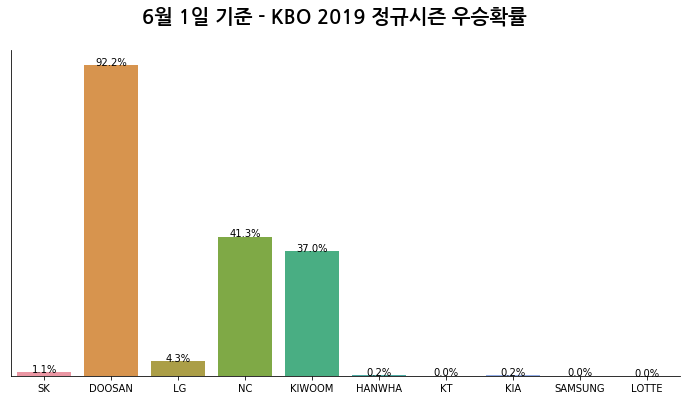

In [28]:
# Draw chart with Seaborn
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=list(predicts.keys()), y=list(predicts.values()), ax=ax)
sns.despine(fig)

ax.grid(False)
ax.set_yticks([])

fig.suptitle('6월 1일 기준 - KBO 2019 정규시즌 우승확률', fontproperties=title_font)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    label = '{:.1f}%'.format(y_value)
    plt.annotate(label, (x_value, y_value), ha='center', fontsize=10)
    
plt.show()


#### 6월 1일 기준 순위 별 우승 확률

초기 예측 모델 작성 시점인 6월 1일 기준 성적은   
SK, 두산, LG, NC, 키움의 순이었으나,   
예측 모델은 두산의 우승 확률을 가장 높게 예측하고 있다.

### 포스트 시즌 진출 예측 모델

KBO는 단일리그로 상위 5위까지 포스트 시즌에 진출 할 수 있는   
조금은 독특한 형태의 리그인데, 우승팀 예측 모델 보다는  
데이터 셋 내에 보다 많은 진출/실패의 경우가 존재하고 있기 때문에,   
비교적 정확한 예측 모델 생성이 가능할 것으로 보인다.


In [29]:
# Train & Test data
X_train, X_test, y_train, y_test = train_test_split(ratio_X, post_y, test_size=.2)

In [30]:
# Set pipeline with SS & Log_Regressor
pp_post_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs', 
                                      random_state=27))
])

In [31]:
# Train model
pp_post_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=27, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [32]:
# Predict and show model performance
test_preds = pp_post_lr.predict(X_test)

In [33]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.78      0.88      0.82         8

   micro avg       0.82      0.82      0.82        17
   macro avg       0.83      0.83      0.82        17
weighted avg       0.83      0.82      0.82        17



In [34]:
# Show odds for playoff
predicts = {}
for team, value in stat_0601.items():
    proba = pp_post_lr.predict_proba([value])[0][1]*100
    predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  75.25%
DOOSAN :  97.9%
 LG :  69.1%
NC :  89.42%
KIWOOM :  96.63%
HANWHA :  1.354%
KT :  1.727%
KIA :  1.176%
SAMSUNG :  18.66%
LOTTE :  0.07711%


In [35]:
def draw_bar_chart(predicts, title, filename='./image/output.png'):
    """Draw a bar chart with Seaborn"""
    # Draw chart with Seaborn
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=list(predicts.keys()), y=list(predicts.values()), ax=ax)
    sns.despine(fig)

    ax.grid(False)
    ax.set_yticks([])

    fig.suptitle(title, fontproperties=title_font)

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        label = '{:.1f}%'.format(y_value)
        plt.annotate(label, (x_value, y_value), ha='center', fontsize=10)

    fig.savefig(filename)
    plt.show()


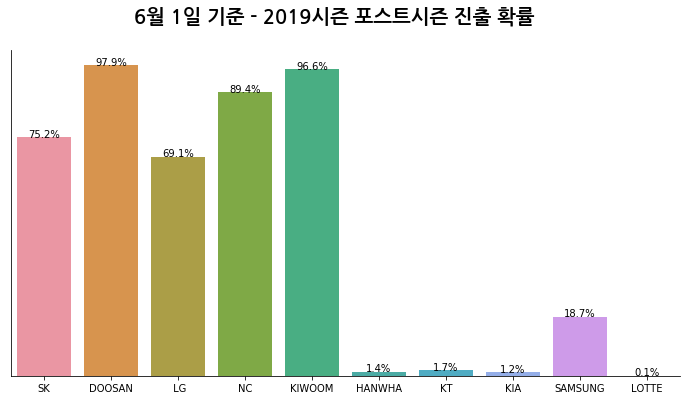

In [36]:
# 6/1 기준 포스트시즌 진출 확률
draw_bar_chart(predicts, title='6월 1일 기준 - 2019시즌 포스트시즌 진출 확률')

### Another prediction at 6/30

In [37]:
# current(30th of June) stat of KBO leagues 
#['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT']

stat_0630 = {
    'SK': [.267, .734, .285, .262, 3.52, 1.31, .984],
    'DOOSAN': [.273, .747, .269, .133, 3.46, 1.33, .985],
    'KIWOOM': [.281, .768, .292, .240, 4.05, 1.35, .981],
    'LG': [.262, .695, .250, .229, 3.50, 1.34, .982],
    'NC': [.281, .766, .280, .153, 4.45, 1.43, .980],
    'KT': [.274, .720, .270, .220, 4.72, 1.46, .979],
    'SAMSUNG': [.269, .752, .265, .234, 4.50, 1.42, .980],
    'KIA': [.265, .717, .254, .186, 4.99, 1.54, .983],
    'HANWHA':[.252, .695, .255, .130, 4.73, 1.52, .980],
    'LOTTE': [.262, .702, .266, .232, 5.10, 1.61, .979],
}

In [38]:
# 우승 확률
new_predicts_to_win = {}
for team, value in stat_0630.items():
    proba = pipeline.predict_proba([value])[0][1]*100
    new_predicts_to_win[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  18.05%
DOOSAN :  62.6%
KIWOOM :  11.49%
LG :  0.8484%
NC :  4.753%
KT :  0.1078%
SAMSUNG :  0.2545%
KIA :  0.07782%
HANWHA :  0.05449%
LOTTE :  0.005813%


In [39]:
new_predicts = {}
for team, value in stat_0630.items():
    proba = pp_post_lr.predict_proba([value])[0][1]*100
    new_predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  96.09%
DOOSAN :  92.58%
KIWOOM :  92.83%
LG :  45.14%
NC :  47.25%
KT :  7.008%
SAMSUNG :  26.38%
KIA :  1.615%
HANWHA :  0.5953%
LOTTE :  0.4565%


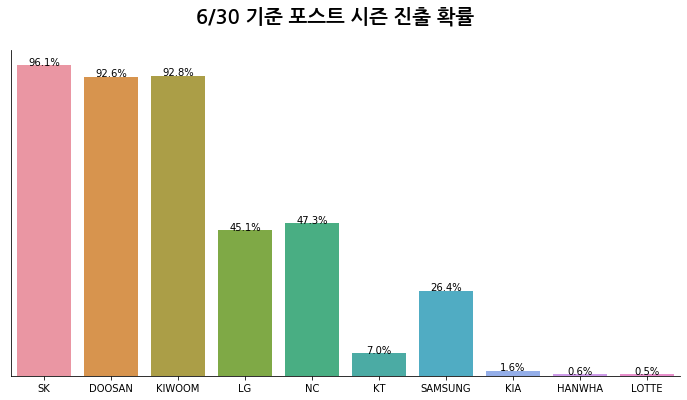

In [40]:
draw_bar_chart(new_predicts, title='6/30 기준 포스트 시즌 진출 확률')

### 6월 30일자 예측

6/30일 현재 SK가 리그를 리드하고 있으며, 두산, 키움 등이 가장 높은 포스트 시즌 진출 확률을   
보이는 형태의 성적을 보여주고 있다. 4위 LG는 상대적으로 낮은 확률을 보이고 있으며,  
하위권인 삼성이 높은 OPS를 바탕으로 비교적 높은 포스트 시즌 진출 확률을 나타내고 있다. 

### 7월 30일 기준 예측 추가

7월 30일 현재 순위와 성적을 바탕으로 포스트 시즌 진출 확률 확인


### KBO 리그 순위표

![0730_Standing](./image/KBO_Standing_190730.png)

In [41]:
# current(30th of July) stat of KBO leagues 
#['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT']

stat_0730 = {
    'SK': [.270, .738, .296, .243, 3.41, 1.29, .984],
    'KIWOOM': [.271, .766, .299, .246, 3.78, 1.32, .981],
    'DOOSAN': [.273, .741, .273, .148, 3.44, 1.32, .984],
    'LG': [.262, .700, .255, .227, 3.69, 1.34, .983],
    'NC': [.281, .765, .276, .171, 4.32, 1.41, .980],
    'KT': [.279, .731, .276, .207, 4.67, 1.45, .981],
    'SAMSUNG': [.267, .748, .259, .247, 4.42, 1.43, .980],
    'KIA': [.265, .717, .260, .203, 4.90, 1.52, .982],
    'HANWHA':[.252, .690, .254, .153, 5.09, 1.55, .980],
    'LOTTE': [.255, .687, .260, .211, 5.17, 1.60, .978],
}

In [42]:
# 7/30일 기준 우승 확률
predicts_to_win_0730 = {}
for team, value in stat_0730.items():
    proba = pipeline.predict_proba([value])[0][1]*100
    new_predicts_to_win[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  49.54%
KIWOOM :  19.26%
DOOSAN :  53.28%
LG :  1.279%
NC :  4.038%
KT :  0.6872%
SAMSUNG :  0.1363%
KIA :  0.07783%
HANWHA :  0.01314%
LOTTE :  0.002214%


In [43]:
# 포스트 시즌 진출 확률
new_predicts = {}
for team, value in stat_0730.items():
    proba = pp_post_lr.predict_proba([value])[0][1]*100
    new_predicts[team] = proba
    print(f'{team} :  {proba:.3}%')

SK :  98.4%
KIWOOM :  96.8%
DOOSAN :  92.6%
LG :  48.2%
NC :  55.3%
KT :  19.7%
SAMSUNG :  21.9%
KIA :  2.6%
HANWHA :  0.206%
LOTTE :  0.138%


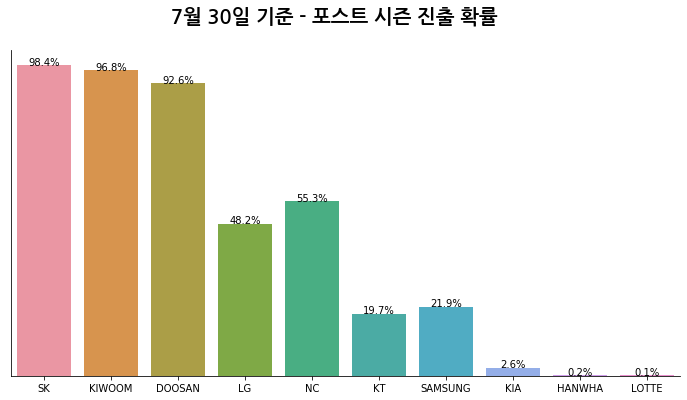

In [44]:
draw_bar_chart(new_predicts, '7월 30일 기준 - 포스트 시즌 진출 확률')

### 7월 30일자 예측

SK, 키움, 두산 상위 3개팀의 포스트시즌 진출이 거의 확실시 되는 가운데,  
독주 중인 SK의 정규리그 우승확률도 50% 가량으로 확인되고 있음.     

DTD 대명사 LG가 취약한 공격력 때문에 4위임에도 불구하고 포스트 시즌 진출 확률이 낮게 나오는 가운데,  
7월 한달 동안 선전한 KT의 확률이 큰폭으로 향상 되었음.  

상대적으로 높은 OPS 등으로 하위권임에도 불구하고 삼성의 포스트 시즌 진출 확률이   
다른 하위권 팀에 비해 높게 나오는 가운데, 기아, 한화, 롯데는 사실상 시즌 아웃 상황임.


### 9월 1일 기준 예측 추가

9월 1일 현재 순위와 성적을 바탕으로 포스트 시즌 진출 확률 확인



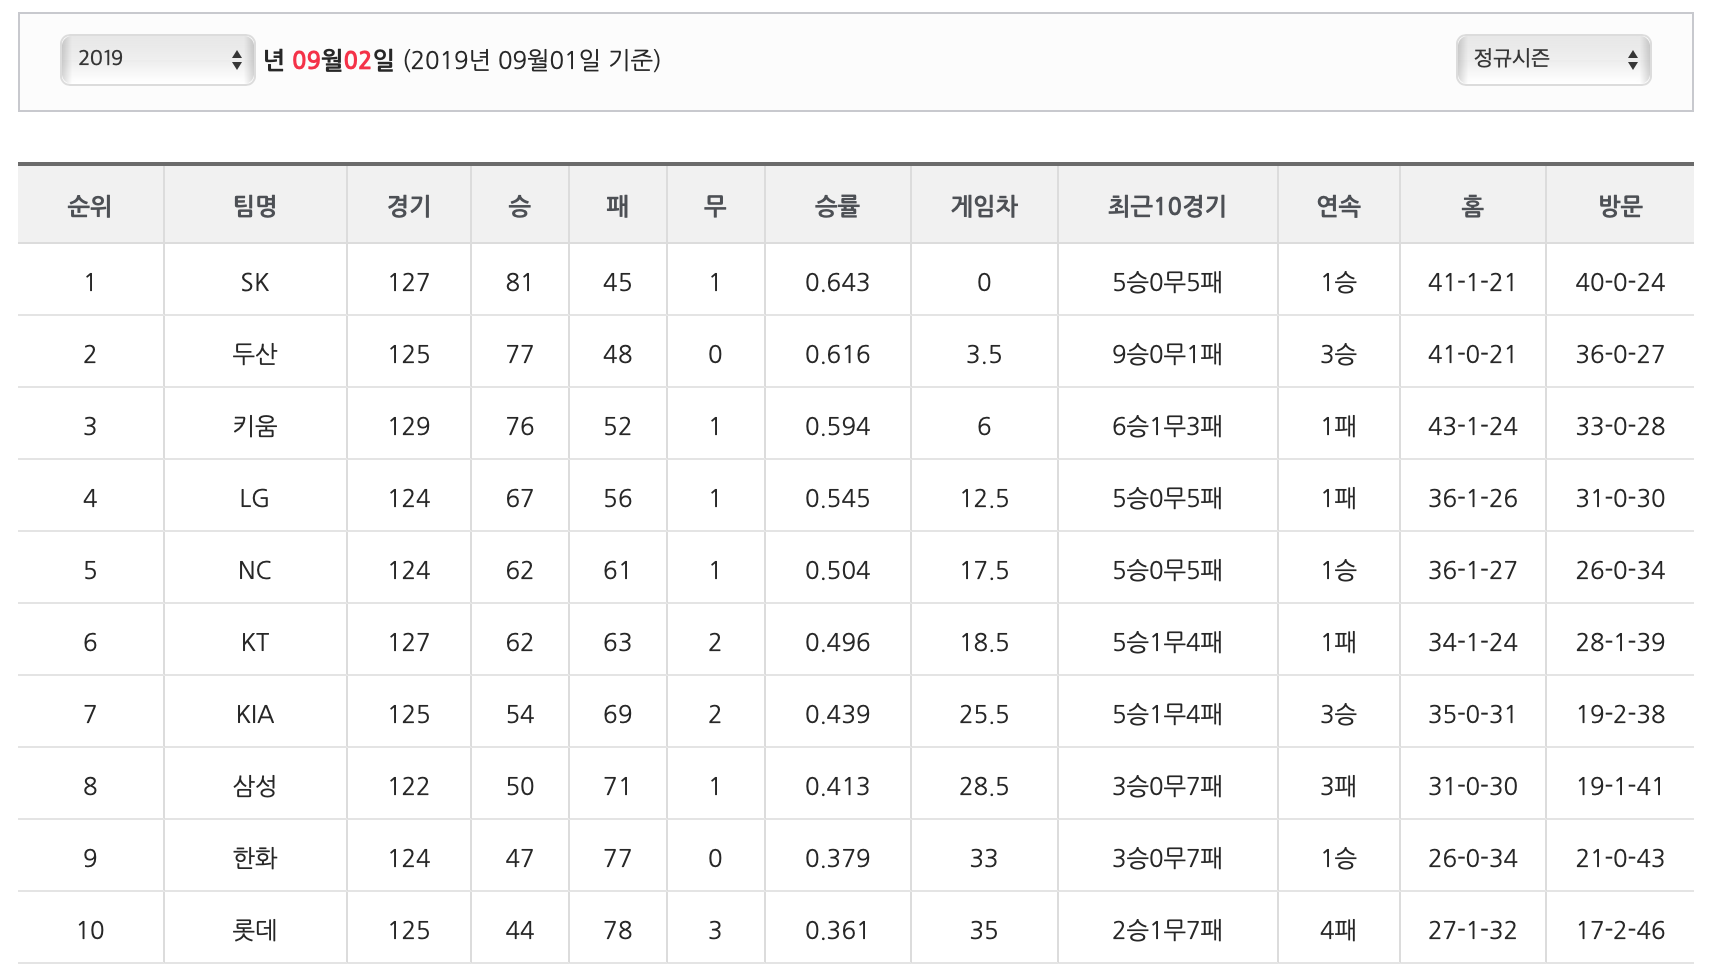

In [52]:
# current(1st of Sep.) stat of KBO leagues 
#['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT']

stat_0901 = {
    'SK': [.266, .724, .286, .250, 3.44, 1.30, .984],
    'DOOSAN': [.277, .753, .278, .179, 3.50, 1.29, .984],
    'KIWOOM': [.285, .781, .303, .274, 3.81, 1.32, .982],
    'LG': [.269, .712, .274, .225, 4.01, 1.39, .983],
    'NC': [.279, .764, .272, .179, 4.18, 1.39, .982],
    'KT': [.278, .727, .273, .209, 4.43, 1.41, .982],
    'KIA': [.267, .718, .261, .204, 4.73, 1.48, .982],
    'SAMSUNG': [.259, .724, .259, .221, 4.69, 1.47, .981],
    'HANWHA':[.254, .687, .257, .170, 5.06, 1.56, .979],
    'LOTTE': [.255, .688, .254, .207, 5.03, 1.57, .978],
}

In [53]:
# 9/1일 기준 우승 확률
predicts_to_win_0901 = {}
for team, value in stat_0901.items():
    proba = pipeline.predict_proba([value])[0][1]*100
    new_predicts_to_win[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  22.54%
DOOSAN :  58.38%
KIWOOM :  36.4%
LG :  2.48%
NC :  7.716%
KT :  1.498%
KIA :  0.1612%
SAMSUNG :  0.069%
HANWHA :  0.008297%
LOTTE :  0.002699%


In [54]:
# 포스트 시즌 진출 확률
new_predicts = {}
for team, value in stat_0901.items():
    proba = pp_post_lr.predict_proba([value])[0][1]*100
    new_predicts[team] = proba
    print(f'{team} :  {proba:.3}%')

SK :  95.9%
DOOSAN :  96.8%
KIWOOM :  99.0%
LG :  53.7%
NC :  70.3%
KT :  34.7%
KIA :  5.54%
SAMSUNG :  5.21%
HANWHA :  0.201%
LOTTE :  0.181%


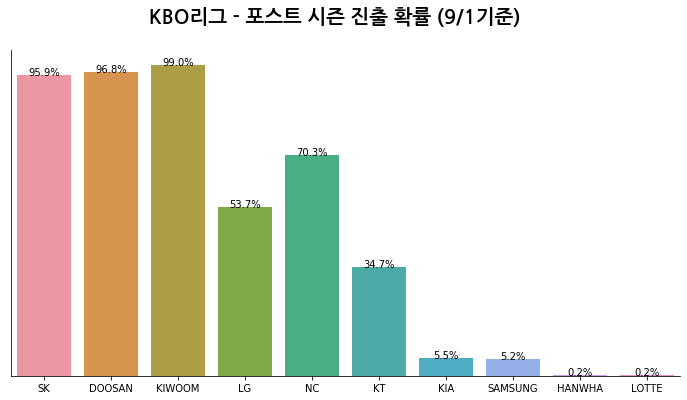

In [55]:
draw_bar_chart(new_predicts, 'KBO리그 - 포스트 시즌 진출 확률 (9/1기준)')

### 9월 1일자 예측

SK, 키움, 두산 상위 3개팀의 포스트시즌 진출이 거의 확실시 되는 가운데,  
독주 중이던 SK를 두산이 3.5게임차로 추격 중인 가운데,
SK의 우승확률보다 두산의 58% 가량으로 확인되고 있음.   
(기존 우승팀들이 공격력을 앞세워 우승을 차지한 가운데, 올해 SK는 투수력과 공격력의 조화를 통해    
좋은 성적을 올리고 있는 상황임)

여전히 LG가 취약한 공격력 때문에 4위임에도 불구하고 포스트 시즌 진출 확률이 낮게 나오는 가운데,  
8월 동안 선전 엎치락 뒷치락 중인 NC와 KT의 경우, NC의 진출 확률이 거의 두배 가량 높은 상황

지난달까지 일말의 희망이 있던 삼성이나 기아도 이제 사실상 경쟁에서 뒤쳐진 상황이고,  
한화와 롯데는 꼴지 예측을 위한 예측 모델을 만들면 어떨까 하는 수준의 치열한 경쟁을 진행 하는 중.
